In [9]:
import os
import numpy as np
import librosa
import librosa.effects
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
from tqdm import tqdm

# Check GPU availability (for Apple Silicon using tensorflow-metal or CPU)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU Enabled")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found; using CPU.")

# Enable mixed precision (if supported)
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("Mixed Precision set to FP16")
except Exception as e:
    print("Could not set mixed precision, falling back to float32")
    policy = mixed_precision.Policy('float32')
    mixed_precision.set_global_policy(policy)

No GPU found; using CPU.
The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Mixed Precision set to FP16


In [10]:
# Set the dataset root folder (update this path as needed)
dataset_root = "Documents/Kashvi/UA_Speech"  # For example, the folder named "UA_Speech" in your working directory

# Define folder names and corresponding class label numbers
# The labels will be: 0 = VERY LOW, 1 = LOW, 2 = MEDIUM, 3 = HIGH
class_mapping = {
    "VERY LOW": 0,
    "LOW": 1,
    "MEDIUM": 2,
    "HIGH": 3
}

In [11]:
# Audio processing parameters:
SAMPLE_RATE = 44100

# For generating mel spectrogram images:
N_MELS = 128         # Number of mel bands (height of the image)
TARGET_FRAMES = 128  # Fixed number of time frames (width of the image)

# Augmentation probabilities
TIME_STRETCH_PROB = 0.3
PITCH_SHIFT_PROB  = 0.3
NOISE_PROB        = 0.3

In [12]:
def extract_mel_image(file_path, n_mels=N_MELS, target_frames=TARGET_FRAMES):
    """
    Loads an audio file, applies *milder* augmentations, then computes the mel spectrogram.
    The dB-scaled spectrogram is clipped to the range [-80, 0] and scaled to [0,1].
    Finally, it pads/crops the time dimension to 'target_frames'.
    """
    # Load audio
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # Reduced augmentation probabilities & intensities:
    # (a) Time Stretch: 20% chance, smaller range
    if np.random.rand() < 0.2:
        rate = np.random.uniform(0.95, 1.05)
        y = librosa.effects.time_stretch(y, rate=rate)

    # (b) Pitch Shift: 20% chance, ±0.5 semitones
    if np.random.rand() < 0.2:
        semitones = np.random.uniform(-0.5, 0.5)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=semitones)

    # (c) Noise Injection: 20% chance, 0.002 variance
    if np.random.rand() < 0.2:
        noise = np.random.normal(0, 0.002, y.shape)
        y = y + noise

    # Compute mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Clip dB range and scale to [0,1]
    mel_db = np.clip(mel_db, -80, 0)
    mel_normalized = (mel_db + 80) / 80

    # Pad or crop
    if mel_normalized.shape[1] < target_frames:
        pad_width = target_frames - mel_normalized.shape[1]
        mel_normalized = np.pad(mel_normalized, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_normalized = mel_normalized[:, :target_frames]
    
    return mel_normalized.astype(np.float32)

In [19]:
def collect_data(dataset_root, class_mapping):
    """
    Recursively collects all .wav files from each class folder defined in class_mapping.
    Extracts mel spectrogram images from each file.
    Returns:
       X: NumPy array of shape (n_samples, n_mels, target_frames, 1)
       y: NumPy array of labels.
    """
    X_list = []
    y_list = []
    
    for folder_name, label in class_mapping.items():
        folder_path = os.path.join(dataset_root, folder_name)
        if not os.path.exists(folder_path):
            print(f"Folder {folder_path} does not exist; skipping.")
            continue
        
        # List all .wav files (case-insensitive)
        wav_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".wav")]
        print(f"Found {len(wav_files)} files in '{folder_name}' folder.")
        
        for wav_file in tqdm(wav_files, desc=f"Processing {folder_name}"):
            file_path = os.path.join(folder_path, wav_file)
            mel_img = extract_mel_image(file_path)  # shape: (n_mels, target_frames)
            X_list.append(mel_img)
            y_list.append(label)
    
    X = np.array(X_list)  # shape (n_samples, n_mels, target_frames)
    y = np.array(y_list)
    # Expand to add channel dimension -> (n_samples, n_mels, target_frames, 1)
    X = np.expand_dims(X, axis=-1)
    return X, y

# Collect the data
X, y = collect_data(dataset_root, class_mapping)
print(f"\nTotal samples collected: {len(X)}")

Found 3825 files in 'VERY LOW' folder.


Processing VERY LOW: 100%|██████████████████| 3825/3825 [14:05<00:00,  4.52it/s]


Found 2281 files in 'LOW' folder.


Processing LOW: 100%|███████████████████████| 2281/2281 [12:37<00:00,  3.01it/s]


Found 2295 files in 'MEDIUM' folder.


Processing MEDIUM: 100%|████████████████████| 2295/2295 [11:20<00:00,  3.37it/s]


Found 3036 files in 'HIGH' folder.


Processing HIGH: 100%|██████████████████████| 3036/3036 [16:55<00:00,  2.99it/s]



Total samples collected: 11437


In [20]:
from sklearn.model_selection import train_test_split

# Split data (80/20) using stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# (Optional) Global normalization – here our images are already in [0,1] from cell 4.
# If needed, you can verify the range:
print("Range X_train:", np.min(X_train), np.max(X_train))

# Build tf.data pipelines:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Range X_train: 0.0 1.0


In [21]:
model = Sequential([
    # Convolutional Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(N_MELS, TARGET_FRAMES, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    # Convolutional Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    # Convolutional Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # NEW Convolutional Block 4 for more capacity
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(256, activation='relu'),  # Increased hidden layer size
    BatchNormalization(),
    Dropout(0.3),
    
    # Output layer for 4 classes
    Dense(4, activation='softmax', dtype=tf.float32)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [22]:
model.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callback: Save the best model (lowest val_loss) to 'best_model.h5'
checkpoint_cb = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Callback: Reduce LR by factor of 0.5 if val_loss doesn't improve for 3 epochs
reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Callback: EarlyStopping with increased patience
early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=7,  # Increased from 5 to 7
    restore_best_weights=True,
    verbose=1
)

# Train the model, applying the new callbacks
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=60,  # You can try 60-100 epochs
    callbacks=[checkpoint_cb, reduce_lr_cb, early_stopping_cb],
    verbose=1
)

Epoch 1/60


2025-04-23 23:49:28.392132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [9149]
	 [[{{node Placeholder/_1}}]]
2025-04-23 23:49:28.999028: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


286/286 [==============================] - ETA: 0s - loss: 1.3953 - accuracy: 0.4818

2025-04-23 23:51:35.662412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2288]
	 [[{{node Placeholder/_1}}]]



Epoch 1: val_loss improved from inf to 1.78156, saving model to best_model.h5
286/286 [==============================] - 137s 476ms/step - loss: 1.3953 - accuracy: 0.4818 - val_loss: 1.7816 - val_accuracy: 0.2605 - lr: 2.0000e-04
Epoch 2/60
286/286 [==============================] - ETA: 0s - loss: 0.9659 - accuracy: 0.6238
Epoch 2: val_loss improved from 1.78156 to 1.38575, saving model to best_model.h5
286/286 [==============================] - 132s 460ms/step - loss: 0.9659 - accuracy: 0.6238 - val_loss: 1.3858 - val_accuracy: 0.4476 - lr: 2.0000e-04
Epoch 3/60
286/286 [==============================] - ETA: 0s - loss: 0.8452 - accuracy: 0.6707
Epoch 3: val_loss improved from 1.38575 to 1.38041, saving model to best_model.h5
286/286 [==============================] - 134s 469ms/step - loss: 0.8452 - accuracy: 0.6707 - val_loss: 1.3804 - val_accuracy: 0.5979 - lr: 2.0000e-04
Epoch 4/60
286/286 [==============================] - ETA: 0s - loss: 0.7499 - accuracy: 0.7087
Epoch 4: val_

In [24]:

test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

72/72 [==============================] - 11s 151ms/step - loss: 0.3022 - accuracy: 0.8859
Test Accuracy: 88.59%


72/72 [==============================] - 14s 188ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.9413    0.9020    0.9212       765
           1     0.9147    0.8706    0.8921       456
           2     0.8011    0.9216    0.8571       459
           3     0.8718    0.8503    0.8609       608

    accuracy                         0.8859      2288
   macro avg     0.8823    0.8861    0.8829      2288
weighted avg     0.8894    0.8859    0.8866      2288

Confusion Matrix:
[[690  17  27  31]
 [ 12 397  24  23]
 [  8   6 423  22]
 [ 23  14  54 517]]


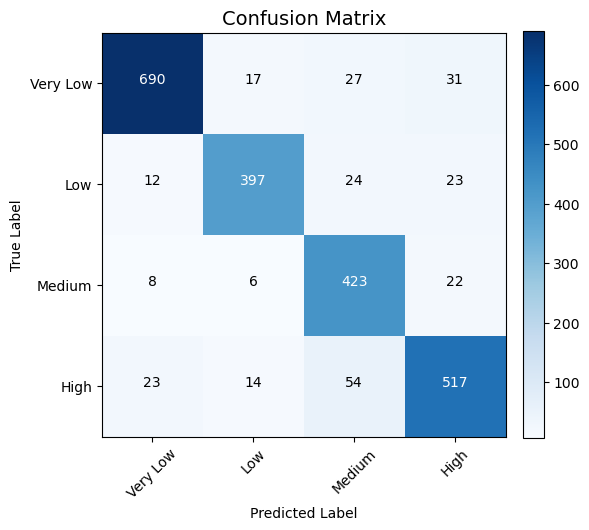

In [25]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
import itertools
from sklearn.metrics import confusion_matrix, classification_report

# Assuming y_test and y_pred are already available:
cm = confusion_matrix(y_test, y_pred)

# Define your class labels in the same order used by the model
class_labels = ['Very Low', 'Low', 'Medium', 'High']

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=14)
plt.colorbar(fraction=0.046, pad=0.04)

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Annotate each cell with its count
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f'{cm[i, j]}',
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

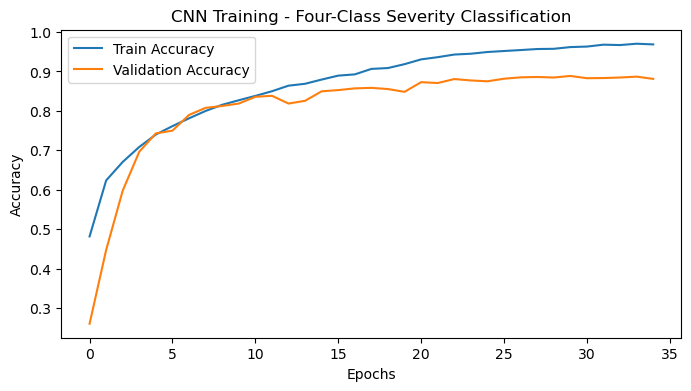

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Training - Four-Class Severity Classification")
plt.legend()
plt.show()

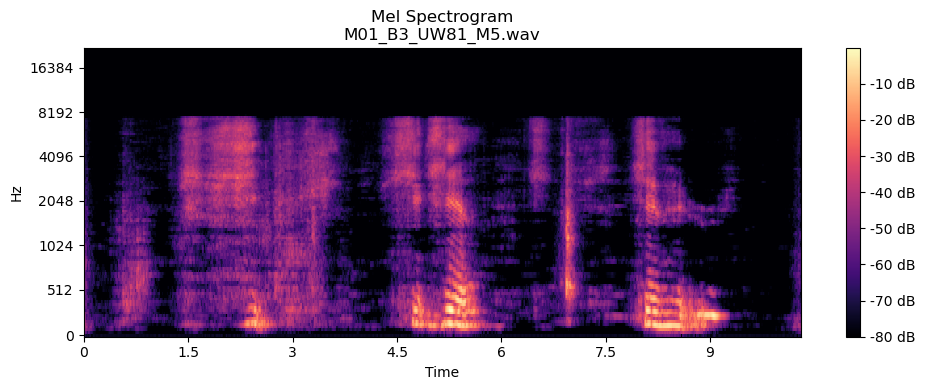

In [27]:
import numpy as np
import os
# Monkey-patch for librosa on modern NumPy
np.complex = complex
np.float   = float

import librosa
import librosa.display
import matplotlib.pyplot as plt

# Audio params
SAMPLE_RATE = 44100
N_MELS      = 128

# Find a .wav file anywhere in the workspace
file_path = None
for root, _, files in os.walk('.'):
    for f in files:
        if f.lower().endswith('.wav'):
            file_path = os.path.join(root, f)
            break
    if file_path:
        break
if not file_path:
    raise FileNotFoundError("No .wav files found in the current directory tree.")

# Load and compute mel spectrogram
y, sr   = librosa.load(file_path, sr=SAMPLE_RATE)
mel     = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
mel_db  = librosa.power_to_db(mel, ref=np.max)
mel_db  = np.clip(mel_db, -80, 0)    # clip to [-80,0] dB

# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(
    mel_db, sr=sr, x_axis='time', y_axis='mel'
)
plt.title(f"Mel Spectrogram\n{os.path.basename(file_path)}")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()



In [28]:
import os
import numpy as np
import librosa
import librosa.effects
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm

# For optional data augmentations (You can adjust probabilities below)
TIME_STRETCH_PROB = 0.3
PITCH_SHIFT_PROB  = 0.3
NOISE_PROB        = 0.3

# Audio parameters
SAMPLE_RATE = 44100
N_MFCC = 20  # Number of MFCC coefficients to extract

# Severity folder mapping: EXACT folder names -> integer labels
class_mapping = {
    "VERY LOW": 0,
    "LOW": 1,
    "MEDIUM": 2,
    "HIGH": 3
}

In [29]:
def extract_features(file_path):
    """
    Loads an audio file, optionally applies augmentation,
    then extracts MFCC and Mel Spectrogram features.

    We'll:
      1) Extract N_MFCC MFCCs -> shape = (N_MFCC, time_frames)
         Average them across time -> shape = (N_MFCC,)
      2) Extract Mel spectrogram -> shape = (n_mels=128, time_frames)
         Convert to dB, average across time -> shape = (128,)

    Finally, we'll concatenate the two average vectors:
      final_feature.shape = (N_MFCC + 128,)
    """
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # Optional data augmentation
    if np.random.rand() < TIME_STRETCH_PROB:
        rate = np.random.uniform(0.9, 1.1)
        y = librosa.effects.time_stretch(y, rate=rate)

    if np.random.rand() < PITCH_SHIFT_PROB:
        semitones = np.random.uniform(-1, 1)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=semitones)

    if np.random.rand() < NOISE_PROB:
        noise = np.random.normal(0, 0.003, y.shape)
        y = y + noise
    
    # MFCC feature extraction
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    mfccs_mean = np.mean(mfccs, axis=1)  # shape (N_MFCC,)

    # Mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)  # shape (128, time_frames)
    mel_mean = np.mean(mel_db, axis=1)             # shape (128,)

    # Concatenate: final shape = (N_MFCC + 128,)
    final_feature = np.hstack((mfccs_mean, mel_mean))
    return final_feature.astype(np.float32)

In [ ]:
def collect_data(dataset_root, class_mapping):
    """
    Scans each folder in class_mapping (e.g., "VERY LOW", "LOW", "MEDIUM", "HIGH")
    and extracts features for each .wav file.

    Returns:
      X: np.array of shape (num_samples, feature_dim)
      y: np.array of labels, shape (num_samples,)
    """
    X_list = []
    y_list = []

    for folder_name, label_val in class_mapping.items():
        folder_path = os.path.join(dataset_root, folder_name)
        if not os.path.exists(folder_path):
            print(f"Folder '{folder_path}' not found, skipping.")
            continue

        # Gather .wav files
        wav_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".wav")]
        print(f"Found {len(wav_files)} WAV files in folder '{folder_name}'.")
        
        for wav_file in tqdm(wav_files, desc=f"Processing {folder_name}"):
            file_path = os.path.join(folder_path, wav_file)
            feats = extract_features(file_path)
            X_list.append(feats)
            y_list.append(label_val)
    
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

# Set your root folder containing VERY LOW, LOW, MEDIUM, HIGH subfolders
dataset_root = "Documents/Kashvi/UA_Speech"  # Adjust to your path
X, y = collect_data(dataset_root, class_mapping)

print(f"\nTotal samples: {len(X)}, feature dimension: {X.shape[1]}")

Found 3825 WAV files in folder 'VERY LOW'.


Processing VERY LOW: 100%|██████████████████| 3825/3825 [11:22<00:00,  5.60it/s]


Found 2281 WAV files in folder 'LOW'.


Processing LOW:  46%|██████████▌            | 1048/2281 [08:20<07:33,  2.72it/s]

In [ ]:
# Ensure we have data
if len(X) == 0:
    raise ValueError("No data collected. Check your folder paths & WAV files.")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features (StandardScaler or MinMaxScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
# Create the SVM model (RBF kernel is common for audio)
svm_model = SVC(kernel='rbf', C=10.0, gamma='scale', random_state=42)

# Fit SVM
svm_model.fit(X_train_scaled, y_train)

# Predict on test
y_pred = svm_model.predict(X_test_scaled)

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Optional: Plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, cmap='Blues')
ax.set_title("Confusion Matrix - SVM")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

# Put class labels
class_labels = ["Very Low", "Low", "Medium", "High"]
ax.set_xticks(range(len(class_labels)))
ax.set_yticks(range(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

# Put text in cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im, ax=ax)
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# We'll reuse `X_train_scaled, y_train` from your existing code,
# and the trained SVC model "svm_model".

# If you have not yet trained svm_model, it's fine;
# we only need the model object with the same hyperparameters.

train_sizes, train_scores, valid_scores = learning_curve(
    svm_model,
    X_train_scaled,
    y_train,
    cv=5,                # 5-fold cross-validation
    scoring='accuracy',
    train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0],  # Fraction of training data to use
    shuffle=True,
    random_state=42
)

# Calculate mean & std for plotting
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std  = np.std(valid_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes,
                 train_mean - train_std,
                 train_mean + train_std,
                 alpha=0.1, color='blue')

plt.plot(train_sizes, valid_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes,
                 valid_mean - valid_std,
                 valid_mean + valid_std,
                 alpha=0.1, color='green')

plt.title('Learning Curve - SVM')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

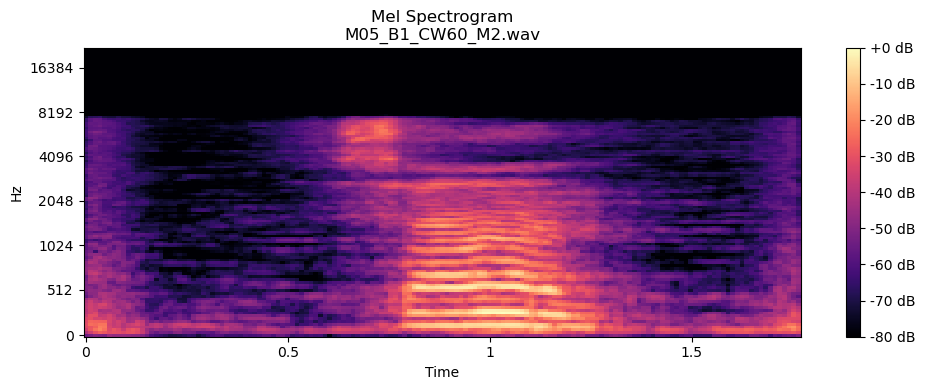

In [5]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Monkey‐patch for librosa compatibility
np.complex = complex
np.float   = float

# Audio params
SAMPLE_RATE = 44100
N_MELS      = 128

# 1) Give your exact file path here:
file_path = "Documents/Kashvi/UA_Speech/LOW/M05_B1_CW60_M2.wav"

# 2) (Optional) sanity check
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

# 3) Load and compute mel spectrogram
y, sr   = librosa.load(file_path, sr=SAMPLE_RATE)
mel     = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
mel_db  = librosa.power_to_db(mel, ref=np.max)
mel_db  = np.clip(mel_db, -80, 0)    # clip to [-80,0] dB

# 4) Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(
    mel_db, 
    sr=sr, 
    x_axis='time', 
    y_axis='mel'
)
plt.title(f"Mel Spectrogram\n{os.path.basename(file_path)}")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()
